# Optimization

In [5]:
import modules
import optimization
import numpy as np
import importlib
importlib.reload(modules)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

max_iter = 2000

def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def print_objective(title, x0, x_name, p):
    print_bold(title+" objective function terms:")
    cost_per_yield, price, fish_yield = modules.obj_terms(x0, x_name, p)
    print(' '*2, "cost_per_yield", "{:10.3f}".format(cost_per_yield), '[$/kg]')
    print(' '*2, "price         ", "{:10.3f}".format(price), '[$]')
    print(' '*2, "fish_yield    ", "{:10.3f}".format(fish_yield), '[kg]')
    print("-"*40)

def print_P_rated(title, x0, x_name, p):
    print_bold(title+" WEC rated power:")
    P_rated = modules.P_rated(x0, x_name, p)
    print(' '*2, "P_rated     ", "{:10.3f}".format(P_rated/1000), '[kW]')
    print("-"*40)

def print_carrying_capacity(title, x0, x_name, p):
    print_bold(title+" carrying capacity:")
    TPF_O2, CC = modules.carrying_capacity_print(x0, x_name, p)
    print(' '*2, "TPF_O2              ", "{:10.3f}".format(TPF_O2), '[kg fish/year]')
    print(' '*2, "Carrying Capacity   ", "{:10.3f}".format(CC), '[kg fish]')
    print("-"*40)
    
def print_ineq_cons(title,x0, x_name, p):
    print_bold(title+" constraints:")
    print(' '*2, "P_gen_cons          ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[0]), '[kWh]')
    print(' '*2, "fish_yield_cons     ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[1]), '[kg]')
    print(' '*2, "env_Umin_cons       ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[2]), '[m/s]')
    print(' '*2, "env_Umax_cons       ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[3]), '[m/s]')
    print(' '*2, "env_tempmin_cons    ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[4]), '[C]')
    print(' '*2, "env_tempmax_cons    ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[5]), '[C]')
    print(' '*2, "env_salinitymin_cons", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[6]), '[PSU]')
    print(' '*2, "env_salinitymax_cons", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[7]), '[PSU]')
    print(' '*2, "env_O2_min_cons     ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[8]), '[mg/l]')
    print("-"*40)
            
def optimize_result(x_name, x_list, x_unit, res, p, opt_idx):
    col_width = len(max(x_list, key=len))
    print(res[opt_idx].success)
    print_bold("optimal design variable:")
    for i in range(len(x_list)):
        print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x_unit[i])
    print("-"*40)

    print_P_rated("optimal",res[opt_idx].x, x_name, p)
    print_objective("optimal",res[opt_idx].x, x_name, p)
    print_ineq_cons("optimal",res[opt_idx].x, x_name, p)
    print_carrying_capacity("optimal",res[opt_idx].x, x_name, p)
    
    
# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_wec','p_fish_salmon']

wec_types = ['point absorber'] #,'attenuator','terminator','point absorber']

# design variables
x_name = ['x_wec','x_pen']
x_list, x0_val, x_unit, x_bnds, x_label = optimization.default_value(x_name)
x0 = []
for i in range(len(x_list)):
    x0.append(x0_val[x_list[i]])

# parameters
param_name = ['x_type_wec','x_env']
param_val = {}

param_val['temp'] =     16  #'C'
param_val['salinity'] = 33  #'[PSU]'
param_val['U'] =        0.2 #'[m/s]'
param_val['O2_in'] =    8   #'[mg/l]'
param_val['wave_height'] = 1.5  #'[m]'     
param_val['wave_period'] = 8.33 #'[s]' 


#optimization
best_idx = 0
res={}

for i in range(len(wec_types)):
    param_val['wec_type'] = wec_types[i]
    p_list, p, p_unit, p_bnds, p_label = optimization.argument_fun(x_name, param_name, param_val, all_vars)
    
    
    print_objective("Initial",x0, x_name, p)
    print_P_rated("Initial",x0, x_name, p)
    print_ineq_cons("Initial",x0, x_name, p)
    print_carrying_capacity("Initial",x0, x_name, p)
    print('+'*40)
    
    res[i], op_obj = optimization.run_optimization(x_name, x0, param_name, param_val, all_vars, max_iter)
    

    if res[i].fun < res[best_idx].fun:
        best_idx = i

optimize_result(x_name, x_list, x_unit, res, p, best_idx)

Initial objective function terms:
   cost_per_yield      6.390 [$/kg]
   price          1382120.251 [$]
   fish_yield     216298.654 [kg]
----------------------------------------
Initial WEC rated power:
   P_rated          71.767 [kW]
----------------------------------------
Initial constraints:
   P_gen_cons            81272.924 [kWh]
   fish_yield_cons       25332.358 [kg]
   env_Umin_cons             0.190 [m/s]
   env_Umax_cons             1.800 [m/s]
   env_tempmin_cons         14.000 [C]
   env_tempmax_cons         12.000 [C]
   env_salinitymin_cons      3.000 [PSU]
   env_salinitymax_cons      2.000 [PSU]
   env_O2_min_cons           3.590 [mg/l]
----------------------------------------
Initial carrying capacity:
   TPF_O2               4126200.708 [kg fish/year]
   Carrying Capacity    241631.013 [kg fish]
----------------------------------------
++++++++++++++++++++++++++++++++++++++++
True
optimal design variable:
   capture_width       2.685 [m]
   pen_diameter       14.908

# Plot fish growth and fish oxygen demand

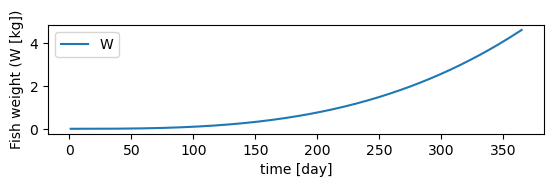

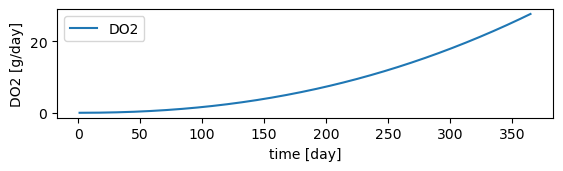

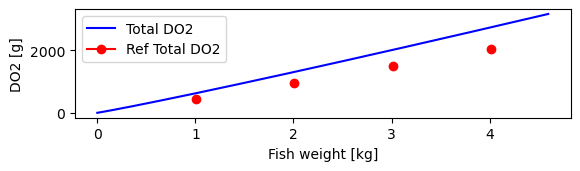

DO2 for 1kg fish 592.658417961274
DO2 for 2kg fish 1267.6196206239329
DO2 for 3kg fish 1968.158657940374
DO2 for 4kg fish 2690.091351663788
fish weight after 365 days 4597.867265255341


In [6]:
x_opt = res[best_idx].x
modules.plot_variable(x_opt, x_name, p)

# Plot objective function and constraints

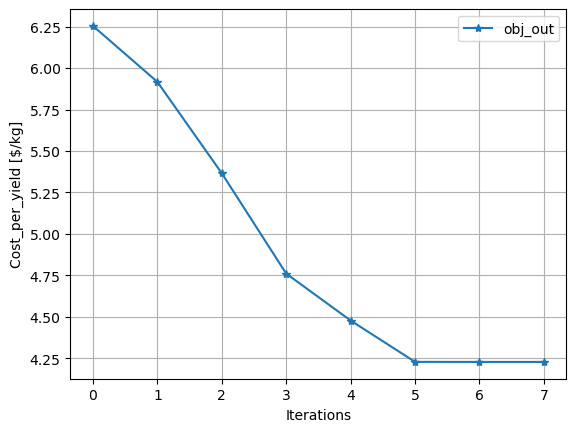

In [7]:
fig, ax = plt.subplots(1,1)
ax.plot(op_obj.f, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)
plt.show()

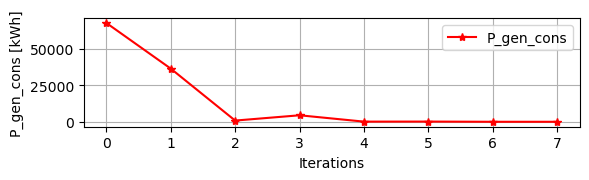

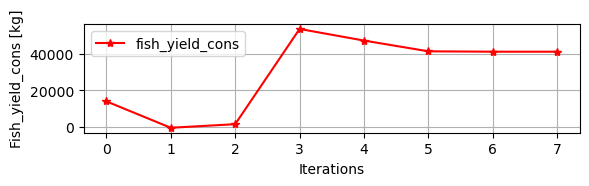

In [8]:
ax1 = plt.subplot(3,1,1)
ax1.plot(op_obj.ineq[:, 0], 'r', label='P_gen_cons', marker='*')
ax1.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax1.legend()
ax1.grid(True)
plt.show()

ax2 = plt.subplot(3,1,2)
ax2.plot(op_obj.ineq[:, 1], 'r', label='fish_yield_cons', marker='*')
ax2.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax2.legend()
ax2.grid(True)
plt.show()
